# Sentiment Analysis & Modeling

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pickle

from collections import Counter, defaultdict
from string import punctuation

import nltk

from textblob import TextBlob

from sklearn.base import TransformerMixin

# preprocessing packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# pipeline tools
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

#feature selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#models
from nltk.sentiment import SentimentIntensityAnalyzer
import xgboost as xgb

#metrics

#custom classes
from preprocessing import preprocess_text

In [2]:
#nltk.download()

In [3]:
#directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
processed_data_folder = parent_directory + '/data/wine-com/processed/'
models_folder = parent_directory + '/models/'

### Load Data

In [4]:
df = pd.read_csv(processed_data_folder + '1677353356.1461694.txt', 
                 sep = '|')

In [5]:
df.head()

,product_url,product_name,product_variety,product_origin,product_family,user_avg_rating,user_rating_count,winemaker_description,reviewer_name,reviewer_rating,reviewer_text
0,https://www.wine.com/product/proyecto-salvaje-...,Proyecto Salvaje del Moncayo Garnacha 2020,Grenache,"from Navarra, Spain",Red Wine,4.8,19,It is a bright burgundy wine with medium-depth...,Decanter,92,part proyecto garnachas de españa collection s...
1,https://www.wine.com/product/proyecto-salvaje-...,Proyecto Salvaje del Moncayo Garnacha 2020,Grenache,"from Navarra, Spain",Red Wine,4.8,19,It is a bright burgundy wine with medium-depth...,Wilfred Wong of Wine.com,91,commentary 2020 proyecto garnachas salvaje del...
2,https://www.wine.com/product/domaine-du-terme-...,Domaine du Terme Gigondas 2019,Rhone Red Blends,"from Gigondas, Rhone, France",Red Wine,4.0,17,NaN,Wine & Spirits,96,spectacular gigondas wine red cherry flavors s...
3,https://www.wine.com/product/domaine-du-terme-...,Domaine du Terme Gigondas 2019,Rhone Red Blends,"from Gigondas, Rhone, France",Red Wine,4.0,17,NaN,Decanter,94,straight first sniff clear going special soari...
4,https://www.wine.com/product/scott-harvey-moun...,Scott Harvey Mountain Selection Zinfandel 2019,Zinfandel,"from Amador, Sierra Foothills, California",Red Wine,4.3,39,Fruit forward rich full flavors expressing bo...,Wine Enthusiast,93,fresh smelling full bodied flavor packed wine ...


In [6]:
df.columns

Index(['product_url', 'product_name', 'product_variety', 'product_origin',
       'product_family', 'user_avg_rating', 'user_rating_count',
       'winemaker_description', 'reviewer_name', 'reviewer_rating',
       'reviewer_text'],
      dtype='object')

### Reduce to Relevant Data

In [7]:
review_data = df[['reviewer_rating','reviewer_text']]

### Missing Data & Data Type Correction

In [8]:
review_data.isnull().sum()

reviewer_rating    0
reviewer_text      4
dtype: int64

Given that this data was scraped there are surpsingly little missing values of relevance. The count of records missing for 'winemaker_description' are inflated by the left join performed during preprocessing. Only the missing values present in 'reviewer_text' will be addressed and since we know that the missing text is due to failed parse. These records will be dropped.

In [9]:
review_data= review_data.dropna(subset = ['reviewer_text'])

In [10]:
review_data['reviewer_rating'] = review_data['reviewer_rating'].astype(int)

In [11]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 0 to 1515
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviewer_rating  1512 non-null   int32 
 1   reviewer_text    1512 non-null   object
dtypes: int32(1), object(1)
memory usage: 29.5+ KB


### Data Assignment & Splitting

In [12]:
# specifying predictive and target features
X = df.drop(columns = ['reviewer_rating'])
y = df[['reviewer_rating']]

In [13]:
# create holdout set to approximate real-world performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

## Rule-based Approach

### NLTK - VADER

The first approach this analysis implements is a rules based approach using VADER and NLTK's SentimentIntensityAnalyzer. Given that this approach does not require labeled training data, it provides a useful baseline for comparison for other models.

In [14]:
class SIATransformer(TransformerMixin):
    def __init__(self):
        sia = SentimentIntensityAnalyzer()
    
    def transform(self, X):
        return [[sia.polarity_scores(doc)['compound']] for doc in X]

    def fit(self, X, y=None):
        return self

In [15]:
# specifiying column transformer fields
text_variables = ['reviewer_text']

# text pipeline:
text_transformer = Pipeline([('text_cleaner', preprocess_text())])

sia_pipeline = Pipeline([('column_transformer', ColumnTransformer([('text', text_transformer, text_variables)],
                                                                   remainder = 'drop')),
                          ('sia_transformer', SIATransformer())])

Since the SIA model values are static, sentiment projection will be performed on entire available dataset.

In [18]:
sia_pipeline.fit(X)
sia_pred = sia_pipeline.transform(X)

NameError: name 'pd' is not defined

In [7]:
sia = SentimentIntensityAnalyzer()

In [8]:
def sia_sentiment(review):
    scores = sia.polarity_scores(review)
    compound_score = scores['compound']
    return compound_score

In [9]:
df['sia_description'] = df['description'].apply(sia_sentiment)
df['sia_reviews'] = df['reviews'].apply(sia_sentiment)

In [10]:
df.groupby('type')['sia_description', 'sia_reviews'].mean()

C:\Users\garyb\AppData\Local\Temp\ipykernel_17672\4015653105.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('type')['sia_description', 'sia_reviews'].mean()


,sia_description,sia_reviews
type,,
Boutique,0.566983,0.538725
Collectible,0.610138,0.535738
Green Wine,0.582320,0.468900
Pink and Rosé,0.714910,0.219517
Red Wine,0.584891,0.434679
Screw Cap,0.642311,0.301414
Sparkling & Champagne,0.709735,0.474191
White Wine,0.628306,0.303999


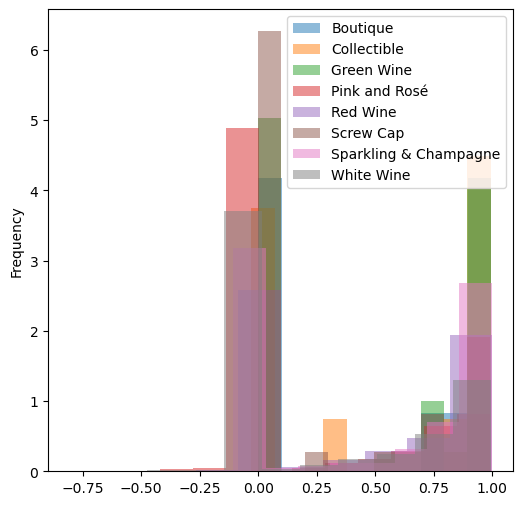

In [12]:
fig = plt.figure(figsize=(6, 6))
df.groupby('type')['sia_reviews'].plot(kind="hist",
                                       density=True,
                                       alpha=0.5,
                                       legend=True)
plt.show()

Lexicon-based approach

### Machine Learning Approach

In [ ]:
# specifiying column transformer fields
text_variables = ['reviewer_text']

# text pipeline:
text_transformer = Pipeline([('text_imputer', SimpleImputer(strategy="constant", fill_value='notextpresent')),
                             ('text_cleaner', preprocessText()),
                             ('count_vectorizer', CountVectorizer())])

full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('cat', cat_pipe, cat_variables)],
                                                                   remainder = 'drop')),
                          ('near_zero_variance', VarianceThreshold()),
                          ('k_best', SelectKBest()),
                          ('xgBoost', xgb.XGBRegressor(objective = 'reg:squarederror',
                                                        tree_method = 'gpu_hist'))])

In [ ]:
search_space = [{'near_zero_variance__threshold': uniform(0.0, 0.2),
                 'k_best__k': randint(10, 100),
                 'xgBoost__n_estimators': randint(100, 2000),
                 'xgBoost__learning_rate': uniform(0.01, 0.3),
                 'xgBoost__max_depth': randint(3, 10),
                 'xgBoost__colsample_bytree': uniform(loc=0.5, scale=0.5),
                 'xgBoost__gamma': uniform(2, 10),
                 'xgBoost__reg_alpha' : uniform(0.00001, 0.3),
                 'xgBoost__reg_lambda' : uniform(0.00001, 0.3)}]


xgb = RandomizedSearchCV(full_pipeline,
                         param_distributions = search_space, 
                         n_iter = 500, 
                         cv = 5,
                         scoring ='neg_root_mean_squared_error',
                         n_jobs = -1,
                        random_state=123)
xgb.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % xgb.best_score_)
print(xgb.best_params_)

In [ ]:
xgb_best_pipeline = xgb.best_estimator_
with open(models_folder + 'sentiment_xgb_best.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Hybrid approach

### Textblob

In [13]:
def tb_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

In [14]:
df['tb_description_polarity'], df['tb_description_subjectivity'] = zip(*df['description'].apply(tb_sentiment))
df['tb_reviews_polarity'], df['tb_reviews_subjectivity'] = zip(*df['reviews'].apply(tb_sentiment))

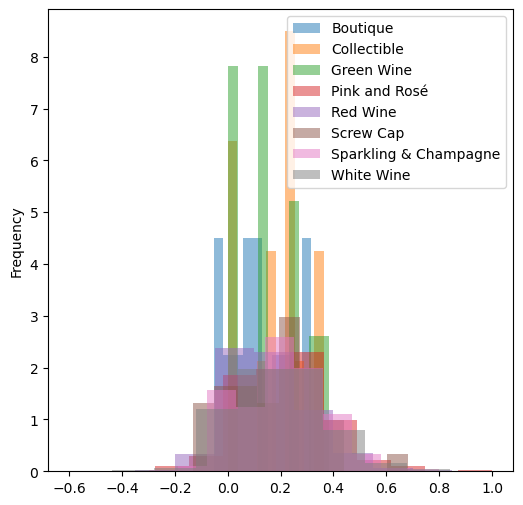

In [15]:
fig = plt.figure(figsize=(6, 6))
df.groupby('type')['tb_description_polarity'].plot(kind="hist",
                                                   density=True,
                                                   alpha=0.5,
                                                   legend=True)
plt.show()

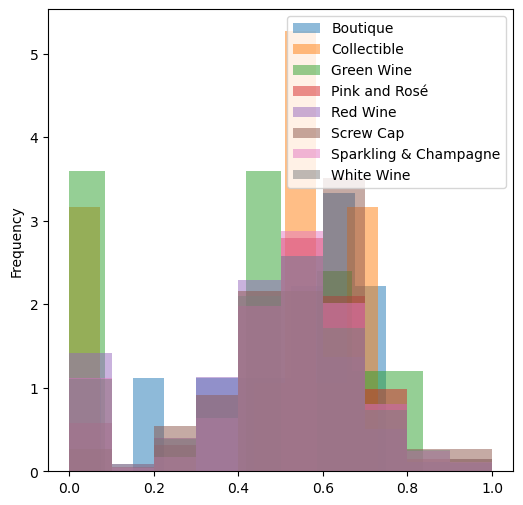

In [16]:
fig = plt.figure(figsize=(6, 6))
df.groupby('type')['tb_description_subjectivity'].plot(kind="hist",
                                                       density=True,
                                                       alpha=0.5,
                                                       legend=True)
plt.show()

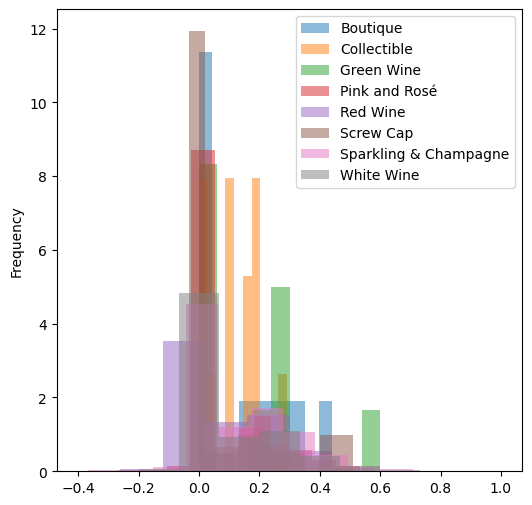

In [17]:
fig = plt.figure(figsize=(6, 6))
df.groupby('type')['tb_reviews_polarity'].plot(kind="hist",
                                               density=True,
                                               alpha=0.5,
                                               legend=True)
plt.show()

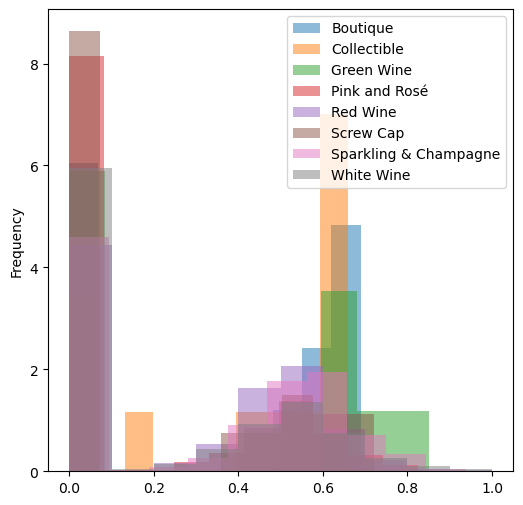

In [18]:
fig = plt.figure(figsize=(6, 6))
df.groupby('type')['tb_reviews_subjectivity'].plot(kind="hist",
                                                   density=True,
                                                   alpha=0.5,
                                                   legend=True)
plt.show()

### SpaCy

In [32]:
def spc_sentiment(text):
    text = str(text)
    doc = nlp(text)
    return doc.sentiment.polarity

In [33]:
df['spc_description'] = df['description'].apply(spc_sentiment)
df['spc_reviews'] = df['reviews'].apply(spc_sentiment)

AttributeError: 'float' object has no attribute 'polarity'